In [394]:
import alphashape
import numpy as np
import os
import pandas as pd


def make_alpha_hull(xy, alpha=1):
    alpha_shape = alphashape.alphashape(xy, alpha)
    xH, yH = alpha_shape.boundary.coords.xy
    return np.vstack([xH, yH]).T


all_data = []
for keyword in ['random', 'kmeans']:
    df = pd.read_csv(os.path.join('data', 'embeddings', f'polymers-umap-{keyword}.txt'), header=None, names=['Sequence', 'Z0', 'Z1'])
    all_data.append(df)

orig_data = pd.concat(all_data)
orig_hull = make_alpha_hull(orig_data.loc[:, 'Z0':'Z1'])

In [395]:
from target_defs import archetype_predictions
from matplotlib import pyplot as plt 

colors = {'oracle': 'tab:blue', 'scientific': 'tab:orange', 'active': 'tab:green', 'evolutionary': 'tab:red', 'random': 'tab:purple'}
labels = {'oracle': 'LLM - Oracle', 'scientific': 'LLM - Scientific', 'active': 'Active Learning', 'evolutionary': 'Evolutionary', 'random': 'Random Selection'}
named_bools = {True: 'seeded', False: 'unseeded'}

base_dir = os.path.join('data')
rollout_data_prefix = "all-rollouts"
ridx = 1
k_data = pd.read_csv(os.path.join(base_dir, f'{rollout_data_prefix}-kltd.csv'))
d_data = pd.read_csv(os.path.join(base_dir, f'{rollout_data_prefix}-topkd.csv'))

experiment_names = ['oracle', 'scientific', 'active', 'evolutionary', 'random']
arch_morphs = ['liquid', 'string', 'membrane', 'vesicle', 'wormlike micelle', 'spherical micelle']

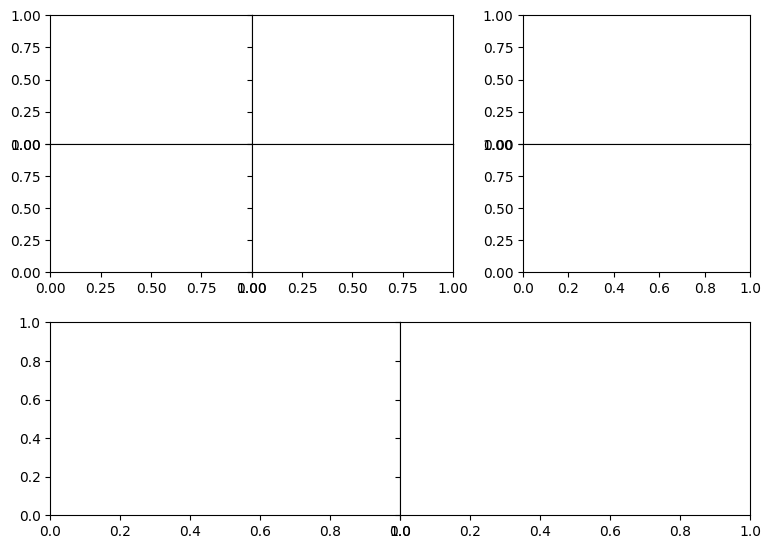

In [396]:
mosaic = """AB
            CD"""

fig = plt.figure(figsize=(7, 5))
top, bot = fig.subfigures(nrows=2, ncols=1, height_ratios=[2, 1.5])
axtl = top.subplot_mosaic(mosaic, sharex=True, sharey=True, 
                         gridspec_kw={"hspace": 0, "wspace": 0,
                                      "bottom": 0.1, "top": 1.0,
                                      "left": 0.0, "right": 0.575},
                         )

mosaic = """E
            F"""
axtr = top.subplot_mosaic(mosaic, sharex=True, sharey=True,
                          gridspec_kw={"hspace": 0.0, "wspace": 0.0,
                                       "bottom": 0.1, "top": 1.0,
                                       "left": 0.675, "right": 1.0})

bot_mos = "GH"
axb = bot.subplot_mosaic(bot_mos, sharex=True, sharey=True,
                         gridspec_kw={"hspace": 0.0, "wspace": 0.0,
                                      "bottom": 0.0, "top": 0.9,
                                      "left": 0.0, "right": 1.0})

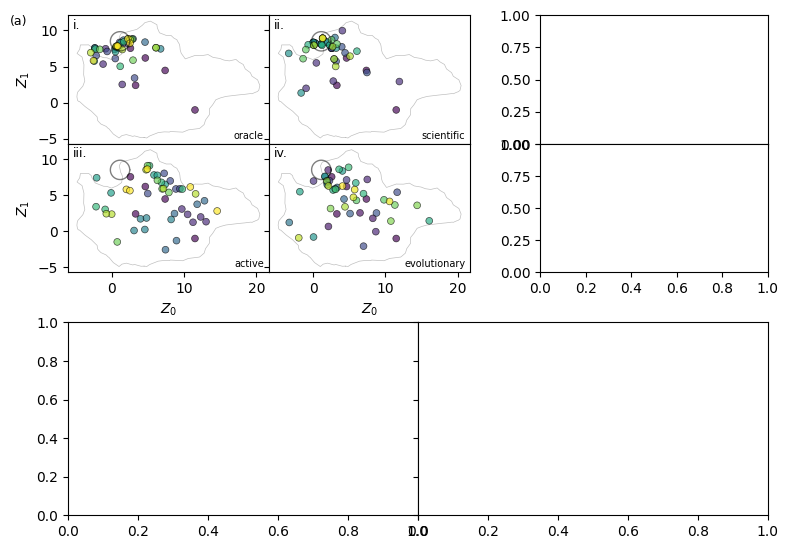

In [397]:
v = archetype_predictions["membrane"]
abc = "abcdefghijkl"
inum = ["i", "ii", "iii", "iv"]

axes = [axtl[it.upper()] for it in abc[:4]]

for fid, experiment in enumerate([it for it in experiment_names if it != "random"]):
    ax = axes[fid]
    
    data = pd.read_csv(os.path.join('data', f'rollout-membrane-{experiment}-{ridx}.csv'), index_col=0)
    if data.shape[0] > 50:
        data = data.iloc[:50, :]  # limit to 50 entries

    im = ax.scatter(*data.loc[:, 'Z0':'Z1'].values.T, c=data.loc[:, 'Iteration']+1, s=24, ec='k', lw=0.5, zorder=1, alpha=0.67)#, vmin=1, vmax=10)
    
    ax.plot(*orig_hull.T, 'k-', lw=0.5, alpha=0.25, zorder=0)
    
    t = np.linspace(0, 2*np.pi)
    circ_points = np.vstack([np.cos(t), np.sin(t)]).T  # radius = 1
    
    ax.plot(*(1.34 * circ_points + v).T, 'k-', lw=1.0, alpha=0.5, zorder=2)
    ax.text(0.975, 0.025, experiment, ha='right', va='bottom', fontsize=7, transform=ax.transAxes)
    ax.text(0.025, 0.975, f'{inum[fid]}.', ha='left', va='top', fontsize=9, transform=ax.transAxes)
    
    ax.set_aspect('equal', adjustable='datalim')
    
    ss = ax.get_subplotspec()
    if ss.is_last_row():
        ax.set_xlabel('$Z_0$')
    if ss.is_first_col():
        ax.set_ylabel('$Z_1$')
axtl["A"].text(-0.20, 1.0, f'(a)', ha='right', va='top', fontsize=9, transform=axtl["A"].transAxes)
fig

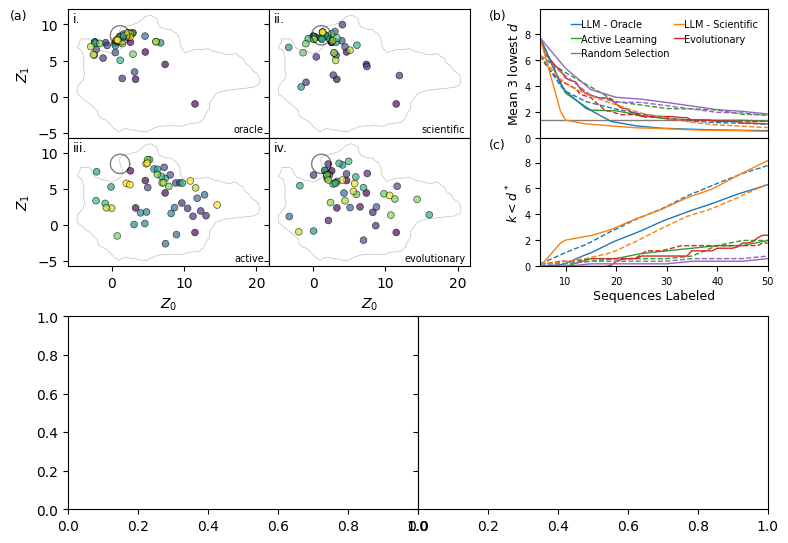

In [398]:
lp = 2  # axis label padding

ax = axtr["F"]

membrane_data = k_data.loc[k_data["Morphology"] == "membrane"]

for (experiment, seed_type), run_data in membrane_data.groupby(["Experiment", "Seed Type"]):
    c = colors[experiment]
    if seed_type == "seeded":
        ls = '-'
        lab = labels[experiment]
    elif seed_type == "unseeded":
        ls = '--'
        lab = None
    else:
        raise ValueError()
    seed_offset = int((seed_type == "seeded"))
    v = run_data.loc[:, "kltd after 1 Labels":].values - seed_offset 
    ax.plot(np.arange(v.shape[1])+1, v.mean(axis=0), color=c, alpha=1.0, lw=1.0, ls=ls, label=lab)

ax.set_ylabel('$k < d^*$', labelpad=lp, fontsize=9)
ax.set_xlabel('Sequences Labeled', labelpad=lp, fontsize=9)
ax.set_xlim(5)
ax.tick_params(axis='both', which='major', labelsize=7)

ax = axtr["E"]

membrane_data = d_data.loc[d_data["Morphology"] == "membrane"]

for (experiment, seed_type), run_data in membrane_data.groupby(["Experiment", "Seed Type"]):
    c = colors[experiment]
    if seed_type == "seeded":
        ls = '-'
        lab = labels[experiment]
    elif seed_type == "unseeded":
        ls = '--'
        lab = None
    else:
        raise ValueError()
    seed_offset = int((seed_type == "seeded"))
    v = run_data.loc[:, "topkd after 1 Labels":].values 
    ax.plot(np.arange(v.shape[1])+1, v.mean(axis=0), color=c, alpha=1.0, lw=1.0, ls=ls)

ax.plot([1, 50], [1.34, 1.34], 'k-', alpha=0.5, lw=1.0, zorder=0)#, label='Threshold')

ax.set_ylabel('Mean 3 lowest $d$', labelpad=lp, fontsize=9)
ax.set_xlabel('Sequences Labeled', labelpad=lp, fontsize=9)
ax.set_ylim(0, 9.9)
ax.set_xlim(5, 50)
ax.tick_params(axis='both', which='major', labelsize=7)

axtr["E"].text(-0.15, 1.0, f'(b)', ha='right', va='top', fontsize=9, transform=axtr["E"].transAxes)
axtr["F"].text(-0.15, 1.0, f'(c)', ha='right', va='top', fontsize=9, transform=axtr["F"].transAxes)

for experiment in ['oracle', 'active', 'random', 'scientific', 'evolutionary']:
    c = colors[experiment]
    axtr["E"].plot(np.nan, np.nan, color=c, alpha=1.0, lw=1.0, ls='-', label=labels[experiment])

axtr["E"].legend(loc='upper right', ncol=2, columnspacing=0.5, borderpad=0.5, handletextpad=0, handlelength=1, fontsize=7, frameon=False)

fig

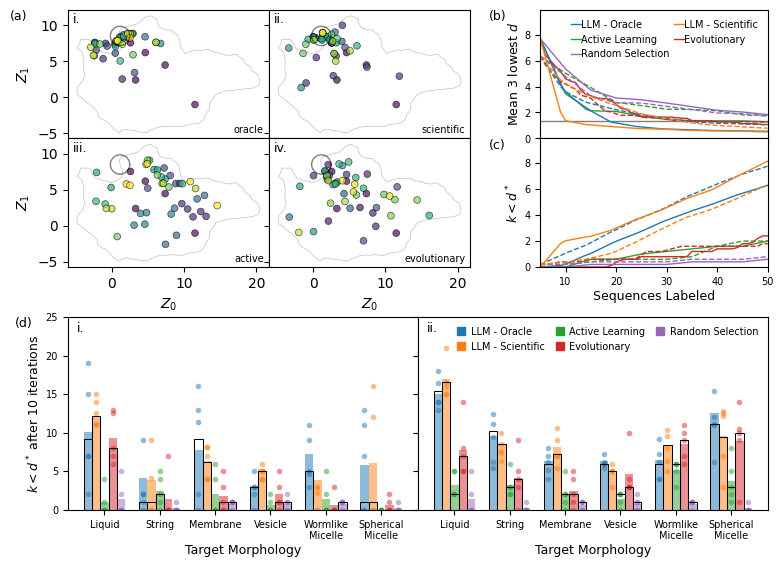

In [399]:
w = 0.15
offs = {'oracle': -2*w, 'scientific': -w, 'active': +0.0, 'evolutionary': w, 'random': 2*w}
axes = [axb["G"], axb["H"]]

for j, use_seed in enumerate([False, True]): 
    ax = axes[j]
    
    for ((experiment, seed_type), exp_data) in k_data.groupby(['Experiment', 'Seed Type']):
        if not (seed_type == named_bools[use_seed]):
            continue
        seed_offset = int((seed_type == "seeded"))
        c = colors[experiment]
        v = []
        for i, morph in enumerate(arch_morphs):
            this_morph = exp_data['Morphology'] == morph
            values = np.nanmax(exp_data.loc[this_morph, 'kltd after 1 Labels':], axis=1) - seed_offset
            pool_values = np.nanmedian(values.reshape(-1, 5), axis=0)  # in case there are multiple meta-replicas
            # pool_values = values
            ax.plot(np.ones(len(pool_values))*(i+1)+offs[experiment], pool_values, color=c, marker='.', ls='none', zorder=1, ms=8, alpha=0.5, mec='none')
            v.append(values)
        ax.bar(np.arange(len(v))+1+offs[experiment], np.mean(v, axis=1), width=w, zorder=0, alpha=0.5, lw=None, color=c)
        ax.bar(np.arange(len(v))+1+offs[experiment], np.median(v, axis=1), width=w, zorder=2, lw=0.75, edgecolor='k', fill=False)
    ax.set_xticks(np.arange(len(arch_morphs))+1, [it.title().replace(' ', '\n') for it in arch_morphs], fontsize=7)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    ax.set_ylim(0, 25)
    ss = ax.get_subplotspec()
    if ss.is_first_col():
        ax.set_ylabel('$k < d^*$ after 10 iterations', labelpad=lp, fontsize=9)
    if ss.is_last_row():
        ax.set_xlabel('Target Morphology', labelpad=lp, fontsize=9)
    
for k in offs.keys():
    axb["H"].plot(np.nan, np.nan, 's', color=colors[k], label=str(labels[k]))
axb["H"].legend(loc='upper right', ncol=3, columnspacing=0.5, borderpad=0.5, handletextpad=0, handlelength=2, fontsize=7, frameon=False)

axb["G"].text(-0.10, 1.0, f'(d)', ha='right', va='top', fontsize=9, transform=axb["G"].transAxes)
axb["G"].text(0.025, 0.975, f'i.', ha='left', va='top', fontsize=9, transform=axb["G"].transAxes)
axb["H"].text(0.025, 0.975, f'ii.', ha='left', va='top', fontsize=9, transform=axb["H"].transAxes)

fig

In [393]:
fig.savefig(os.path.join('figures', 'rev2', 'fig2-v4.pdf'), dpi=600, bbox_inches='tight')